In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [ ]:
from imutils import paths
import random

In [ ]:
# Set paths to train and validation folders
train_path = "/content/drive/MyDrive/dataset/cucumber/train"
valid_path = "/content/drive/MyDrive/dataset/cucumber/test"

In [ ]:
# Visualising data
names = []
nums = []

data = {'Name of class' :[], 'Number of samples':[]}

for i in os.listdir(train_path):
  nums.append(len(os.listdir(train_path +'/'+ i)))
  names.append(i)

data['Name of class'] += names
data['Number of samples'] += nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,Fresh Leaf,128
1,Pythium Fruit Rot,135
2,Gummy Stem Blight,128
3,Downy Mildew,128
4,Bacterial Wilt,128
5,Anthracnose,128
6,Belly Rot,128
7,Fresh Cucumber,128


from matplotlib import pyplot as plt
df['Number of samples'].plot(kind='hist', bins=20, title='Number of samples')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Name of class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Number of samples'].plot(kind='line', figsize=(8, 4), title='Number of samples')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Name of class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Number of samples', y='Name of class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
classes = df['Name of class']

plt.figure(figsize=(30, 30))
for x in range(10):
  i = random.randint(0,7)

  images = os.listdir(train_path+'/'+classes[i])
  j = random.randint(0, 127)

  image = cv2.imread(train_path+'/'+classes[i]+'/'+images[j])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ax = plt.subplot(5, 5, x + 1)
  plt.imshow(image)
  plt.title(classes[i], fontsize=27)
  plt.axis("off")

plt.show()

Data Preprocessing with ImageDataGenerator

In [ ]:
# Define image data generators with data augmentation
image_size = (224, 224)
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    directory = valid_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 1031 images belonging to 8 classes.
Found 258 images belonging to 8 classes.


In [ ]:
num_classes = len(classes)
num_classes

8

In [ ]:
# Build the model based on transfer learning
mobilenet = MobileNetV2(input_shape = (224,224,3), include_top=False, weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name ='classification'))

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 average_pooling2d (Average  (None, 3, 3, 1280)        0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                           

In [ ]:
# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
print("Starting train!")
# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps= len(valid_generator),
    callbacks=[early_stopping]
)

Starting train!
Epoch 1/30
65/65 [==============================] - 582s 9s/step - loss: 1.8531 - accuracy: 0.3996 - val_loss: 1.0420 - val_accuracy: 0.5969
Epoch 2/30
65/65 [==============================] - 218s 3s/step - loss: 0.9822 - accuracy: 0.6518 - val_loss: 1.0754 - val_accuracy: 0.6395
Epoch 3/30
65/65 [==============================] - 236s 4s/step - loss: 0.7069 - accuracy: 0.7468 - val_loss: 1.4690 - val_accuracy: 0.6395
Epoch 4/30
65/65 [==============================] - 228s 4s/step - loss: 0.5894 - accuracy: 0.8080 - val_loss: 1.1287 - val_accuracy: 0.6977
Epoch 5/30
65/65 [==============================] - 230s 4s/step - loss: 0.5002 - accuracy: 0.8293 - val_loss: 1.2635 - val_accuracy: 0.6977
Epoch 6/30
65/65 [==============================] - 229s 4s/step - loss: 0.4279 - accuracy: 0.8603 - val_loss: 1.2827 - val_accuracy: 0.6938
Epoch 7/30
65/65 [==============================] - 228s 3s/step - loss: 0.3694 - accuracy: 0.8749 - val_loss: 1.4733 - val_accuracy: 0.68

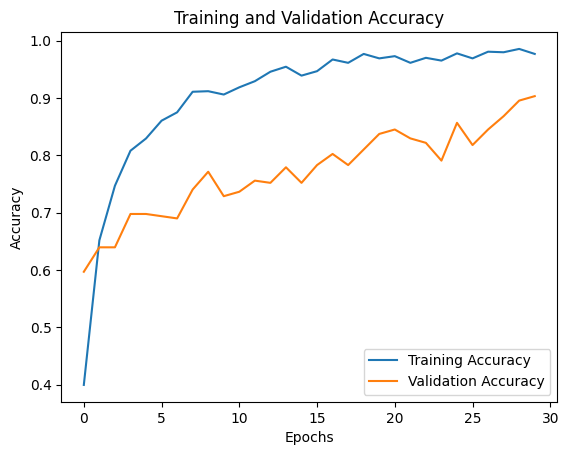

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

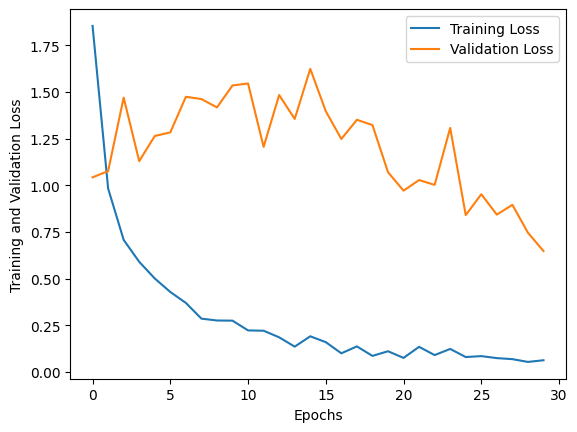

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label= "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("/content/drive/MyDrive/my_models/trained_model_cucu.h5")
print("Trained model saved as 'trained_model.h5'")

17/17 [==============================] - 15s 848ms/step - loss: 0.6472 - accuracy: 0.9031
Test Loss: 0.6472
Test Accuracy: 0.9031


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model saved as 'trained_model.h5'


In [ ]:
classes = ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']

1/1 [==============================] - 0s 50ms/step


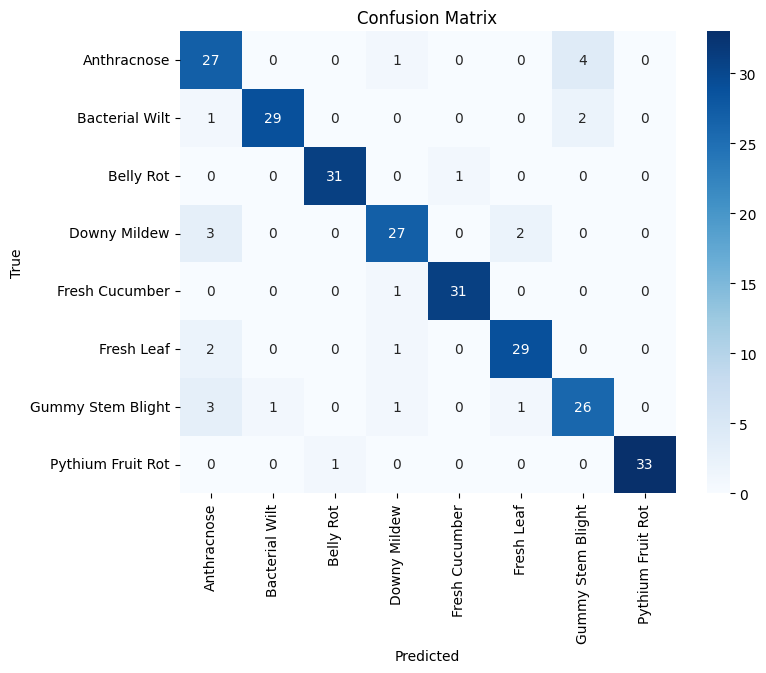

                   precision    recall  f1-score   support

      Anthracnose       0.75      0.84      0.79        32
   Bacterial Wilt       0.97      0.91      0.94        32
        Belly Rot       0.97      0.97      0.97        32
     Downy Mildew       0.87      0.84      0.86        32
   Fresh Cucumber       0.97      0.97      0.97        32
       Fresh Leaf       0.91      0.91      0.91        32
Gummy Stem Blight       0.81      0.81      0.81        32
Pythium Fruit Rot       1.00      0.97      0.99        34

         accuracy                           0.90       258
        macro avg       0.91      0.90      0.90       258
     weighted avg       0.91      0.90      0.90       258



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import os
import glob
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/my_models/trained_model_cucu.h5")

# Path to the test images folder
test_folder = '/content/drive/MyDrive/dataset/cucumber/test'

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through each class folder in the test set
for class_folder in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_folder)

    # Check if the item is a directory
    if os.path.isdir(class_path):
        # List all image files in the class folder
        image_files = glob.glob(os.path.join(class_path, '*.jpg'))

        # Loop through each image in the class
        for image_path in image_files:
            # Load and preprocess the input image
            img = image.load_img(image_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = valid_datagen.standardize(img_array)  # Use the same ImageDataGenerator for preprocessing

            # Make predictions
            predictions = loaded_model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Extract true label from the class folder name
            true_label = class_folder

            # Append true and predicted labels to the lists
            true_labels.append(true_label)
            predicted_labels.append(classes[predicted_class])

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(true_labels)),
            yticklabels=sorted(set(true_labels)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels))


In [ ]:
print(predicted_labels)

['Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Belly Rot', 'Pythium Fruit Rot', 'Belly Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Fresh Leaf', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh Cucumber', 'Fresh C

In [ ]:
print(true_labels)

['Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Bacterial Wilt', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Pythium Fruit Rot', 'Py

In [ ]:
data['Name of class'][3]

'Downy Mildew'

In [ ]:
# Set your image dimensions
image_dims = (224, 224, 3)
batch_size = 16

dataPath = "/content/drive/MyDrive/dataset/cucumber_disease"

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             width_shift_range=0.2,height_shift_range=0.2
                             )

generator = datagen.flow_from_directory(dataPath,
                                                target_size=(image_dims[0], image_dims[1]),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical')

Found 1289 images belonging to 8 classes.


In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/dataset/cucumber_disease")))
# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

# data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

AttributeError: ignored

In [ ]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(1289, 224, 224, 3)


In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

1. Anthracnose
2. Bacterial Wilt
3. Belly Rot
4. Downy Mildew
5. Fresh Cucumber
6. Fresh Leaf
7. Gummy Stem Blight
8. Pythium Fruit Rot


In [ ]:
def build_model(input_shape,class_number):
    baseModel = MobileNetV3Small(include_top=False,weights = 'imagenet',input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [ ]:
size = (224, 224)
shape = (224, 224, 3)
class_number = 16

model = build_model(shape, class_number)